# Processing and plotting of ApRES data from season 1 on Flask Glacier

These data were collected by a field team consisting of Ben Davison, Kate Winter, and Rohi Muthyala in Dec 2024. 

One ApRES unit was deployed in unattended mode on the glacier at site 2 (the upstream site int eh diamond around the main lake)

In [3]:
import sys
sys.path.append('/Users/jkingslake/Documents/science/ApRES/xapres')
import xapres as xa
import matplotlib.pyplot as plt
import hvplot.xarray
import pandas as pd
import numpy as np
import xarray_grid_search as xgs
import xarray as xr


/Users/jkingslake/Documents/projects/current_projects/AntPen_NSF_NERC/AntPen_NSF_NERC/code/apres/season_1/xarray_grid_search.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## find the dat files. 
I downloaded these from the google drive (https://drive.google.com/drive/u/0/folders/1_k0hUaA3EOMDIX2tSgT6PgfXj63OCZ6T?ths=true). 

I also put them in the google bucket (gs://ldeo-glaciology/apres/flask/ApRES Season1/7.12.2024_Site2_unattended/Data/). To load from there use:

```
file_names = fd.list_files("gs://ldeo-glaciology/apres/flask/ApRES Season1/7.12.2024_Site2_unattended/Data/")
```

this is open to everyone.

In [3]:
fd = xa.load.from_dats()
data_directory = '../../../data/flask/ApRES Season1/7.12.2024_Site2_unattended/Data/'
file_names = fd.list_files(data_directory)
len(file_names)

97

## Load the data into an xarray dataset

In [76]:
ds = xa.load.generate_xarray(data_directory, computeProfiles=False)
ds = ds.sortby('time').mean('chirp_num')
ds = ds.assign_coords({"time": ds.time- np.timedelta64(3, 'h')})
ds.time.attrs['long_name'] = 'time (PA time: UTC-3hrs)'
ds_c = ds.isel(time = slice(5,-1))
stacked = ds_c.addProfileToDs()
w = stacked.profile.displacement_timeseries(max_depth_for_ezz_fit = 400, offset = 6)


In [77]:
ds_c

<xarray.Dataset>
Dimensions:          (time: 94, attenuator_setting_pair: 2, chirp_time: 40000)
Coordinates:
  * chirp_time       (chirp_time) float64 0.0 2.5e-05 5e-05 ... 0.9999 1.0 1.0
    filename         (time) <U23 'DATA2024-12-08-1958.DAT' ... 'DATA2024-12-1...
    folder_name      (time) <U4 'Data' 'Data' 'Data' ... 'Data' 'Data' 'Data'
    burst_number     (time) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    AFGain           (time, attenuator_setting_pair) int64 -4 -14 -4 ... -4 -14
    attenuator       (time, attenuator_setting_pair) float64 20.0 10.0 ... 10.0
    orientation      (time) <U7 'unknown' 'unknown' ... 'unknown' 'unknown'
  * time             (time) datetime64[ns] 2024-12-08T16:58:30 ... 2024-12-12...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (time, attenuator_setting_pair, chirp_time) float64 0.01...
    latitude         (time) float64 -65.78 -65.78 -65.78 ... -65.78 -65.78
    longitude        (time) float64 -62.69 -62.69 -62.69 ... -62.69 -62.69
    battery_voltage  (time) float64 12.89 12.73 12.69 ... 12.15 12.15 12.14
    temperature_1    (time) float64 27.51 45.15 44.36 ... 26.33 24.96 25.16
    temperature_2    (time) float64 29.88 44.39 40.27 ... 25.17 26.55 26.94

## (very) exploratory plotting

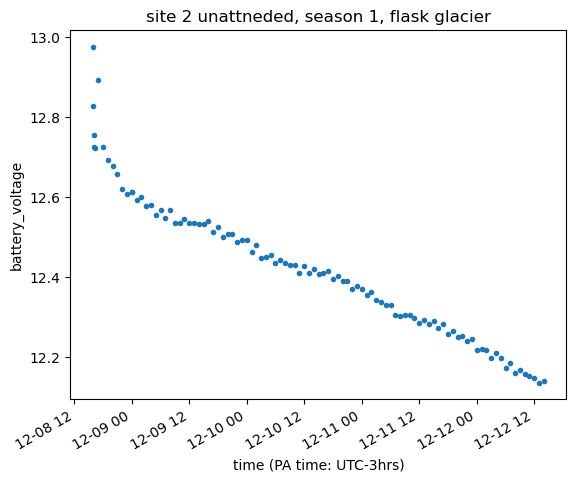

In [78]:
ds.battery_voltage.plot(marker = '.', linestyle = '');
plt.title('site 2 unattneded, season 1, flask glacier')
plt.savefig('battery_voltage.png')


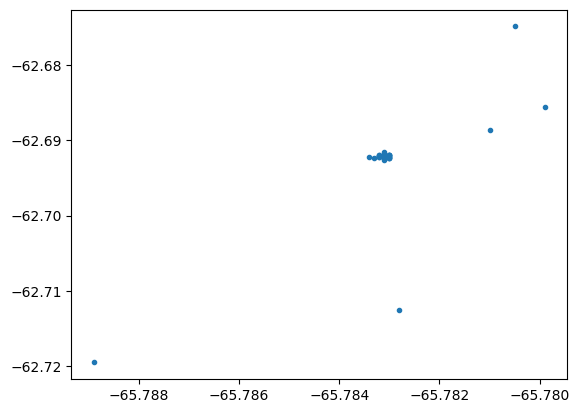

In [79]:
plt.plot(ds.latitude, ds.longitude, marker = '.', linestyle = '');

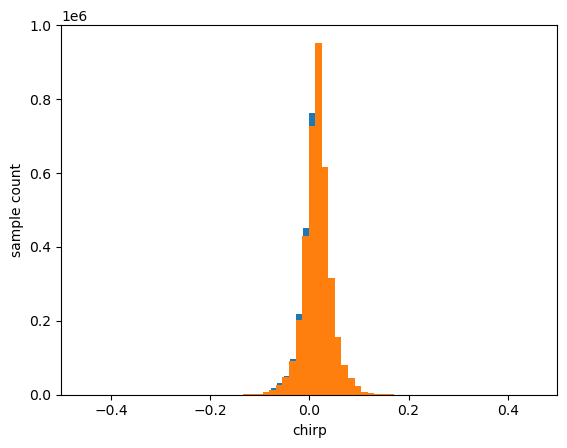

In [80]:
ds_c.chirp.isel(attenuator_setting_pair = 0).plot.hist(bins=50, xlim = (-0.5, 0.5))
ds_c.chirp.isel( attenuator_setting_pair = 1).plot.hist(bins=50, xlim = (-0.5, 0.5));
plt.ylabel('sample count');

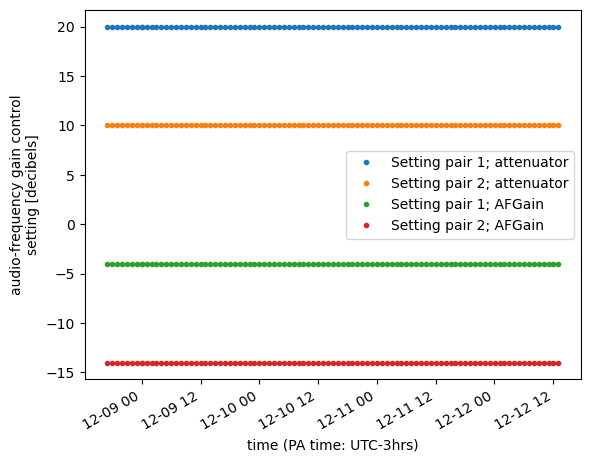

In [84]:
ds_c.attenuator.isel(attenuator_setting_pair = 0).plot(marker = '.', linestyle = '', label = 'Setting pair 1; attenuator')
ds_c.attenuator.isel(attenuator_setting_pair = 1).plot(marker = '.', linestyle = '', label = 'Setting pair 2; attenuator')
ds_c.AFGain.isel(attenuator_setting_pair = 0).plot(marker = '.', linestyle = '', label = 'Setting pair 1; AFGain')
ds_c.AFGain.isel(attenuator_setting_pair = 1).plot(marker = '.', linestyle = '', label = 'Setting pair 2; AFGain')
plt.legend()

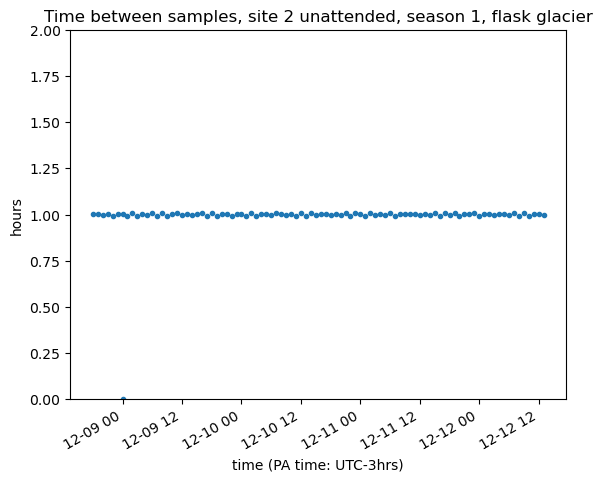

In [85]:
(ds_c.time.diff('time').astype('float64')/1e9/60/60).plot(marker = '.', linestyle = '', ylim=[0, 2])
plt.title('Time between samples, site 2 unattended, season 1, flask glacier')
plt.ylabel('hours')
plt.savefig('measurement_interval.png')


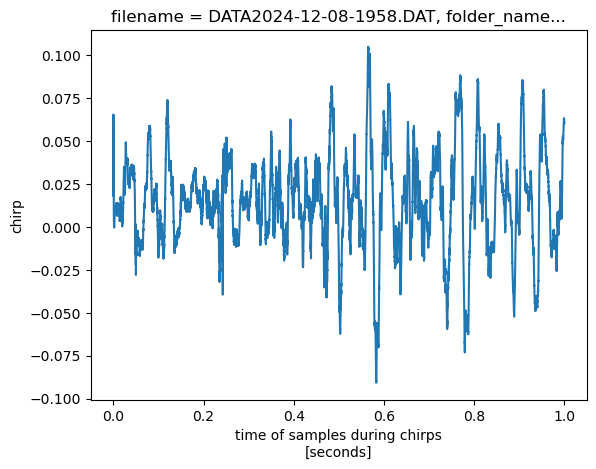

In [86]:
ds_c.chirp.isel(time=0, 
                attenuator_setting_pair = 0).plot()

In [87]:
ds_c.chirp.isel(time=20).hvplot(x='chirp_time', y = 'chirp', by = 'attenuator_setting_pair', )

:NdOverlay   [attenuator_setting_pair]
   :Curve   [chirp_time]   (chirp)

In [88]:
stacked.profile.sel(profile_range = slice(0,2000)).dB().hvplot(x='profile_range', y = 'profile', by = 'attenuator_setting_pair', ylim = (-140, -40), xlim = (0, 600), height = 600, width = 800)

BokehModel(combine_events=True, render_bundle={'docs_json': {'1578bf81-21ed-4aa1-9c9f-1215e211ec05': {'version…

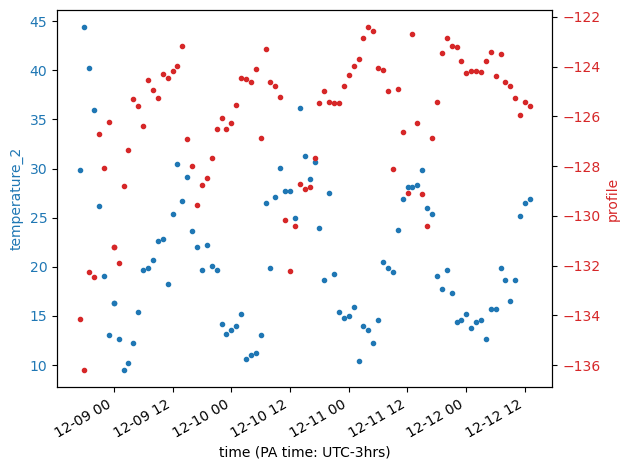

In [112]:
fig, ax1 = plt.subplots()

# Plot the first dataset on the first y-axis
color = 'tab:blue'
ax1.set_xlabel('X-axis label')
ax1.set_ylabel('Temperature 2', color=color)
ds_c.temperature_2.plot(ax=ax1, marker = '.', linestyle = '', color=color)
#ds_c.temperature_1.plot(ax=ax1, marker = '.', linestyle = '')


#ax1.plot(ds_c.temperature_2, marker='.', linestyle='', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Temperature 1', color=color)
stacked.profile.isel(attenuator_setting_pair = 0).sel(profile_range = slice(20,480)).mean(['profile_range']).dB().plot(ax=ax2, marker = '.', linestyle = '', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [125]:
stacked.profile.isel(attenuator_setting_pair = 0).sel(profile_range = slice(20,480)).mean(['profile_range']).dB().hvplot(x = 'time')


:Curve   [time]   (profile)

In [123]:
def mean_profile(d1, d2):
    return stacked.profile.isel(attenuator_setting_pair = 0).sel(profile_range = slice(d1,d2)).mean(['profile_range']).dB()
out = xgs.gridSearch(mean_profile, d1 = range(0, 200, 5), d2 = range(0, 200, 5))
out.hvplot(x = 'time')

  0%|          | 0/1600 [00:00<?, ?it/s]

BokehModel(combine_events=True, render_bundle={'docs_json': {'f8d45a32-31b1-495d-a463-8fd53d4b4419': {'version…

In [108]:
out

<xarray.Dataset>
Dimensions:  (d1: 100, d2: 100, time: 94)
Coordinates:
  * d1       (d1) int64 0 10 20 30 40 50 60 70 ... 930 940 950 960 970 980 990
  * d2       (d2) int64 100 110 120 130 140 150 ... 1050 1060 1070 1080 1090
Dimensions without coordinates: time
Data variables:
    result   (time, d1, d2) float64 -126.4 -123.0 -141.8 ... -175.1 -176.8

In [117]:
(w.velocity-w.velocity.isel(bin_depth=50)).hvplot(x = 'velocity', y = 'bin_depth', by ='attenuator_setting_pair',  ylim = (500, 0), xlim=(-40, 40))

BokehModel(combine_events=True, render_bundle={'docs_json': {'813d3c6f-7790-4cb8-89b2-88c5db249763': {'version…

In [97]:
import numpy as np
np.abs(w.coherence).hvplot(x='bin_depth', y = 'coherence', by = 'attenuator_setting_pair', xlim = (0, 1000), ylim= (0, 1))

BokehModel(combine_events=True, render_bundle={'docs_json': {'61bb099d-a70f-458a-935b-8e106f5ddcbb': {'version…

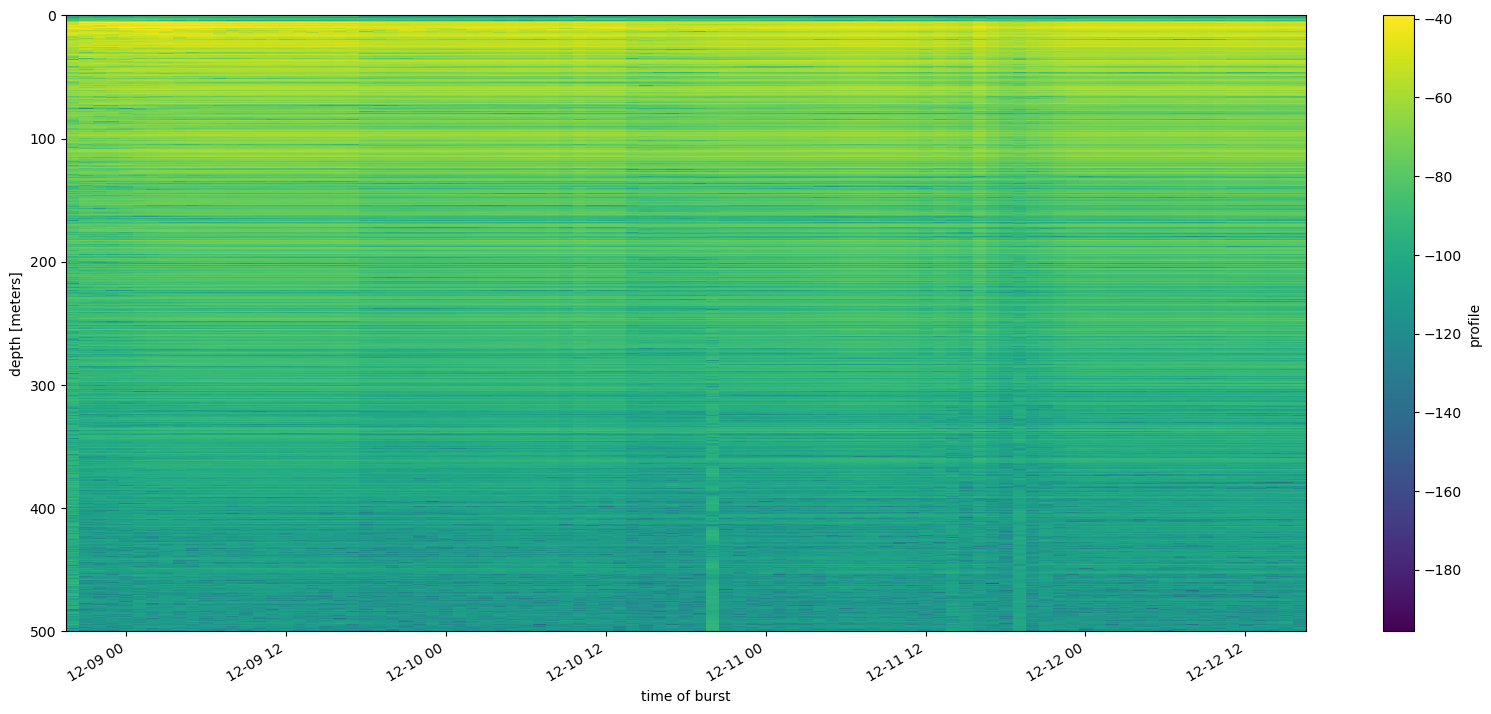

In [130]:
stacked.profile.dB().sel(attenuator_setting_pair = 1).plot(x = 'time', ylim = (500, 0), figsize = (20, 8));
#plt.title('power: site 2 unattneded, season 1, flask glacier')
#plt.savefig('power.png')

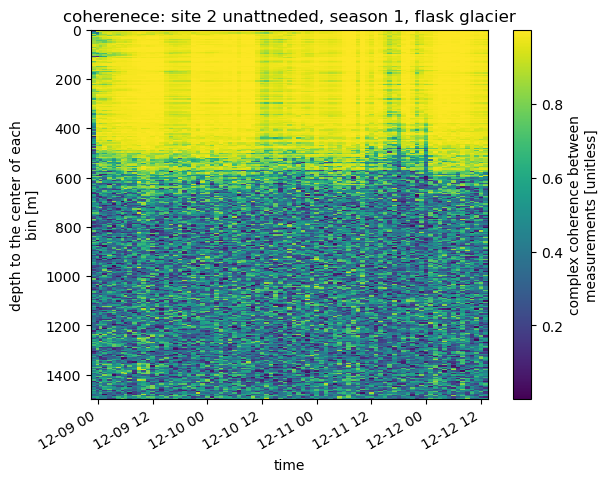

In [ ]:
np.abs(w.coherence).sel(attenuator_setting_pair = 0).plot(x = 'time', ylim = (1500, 0));
plt.title('coherenece: site 2 unattneded, season 1, flask glacier')
plt.savefig('coherence.png')

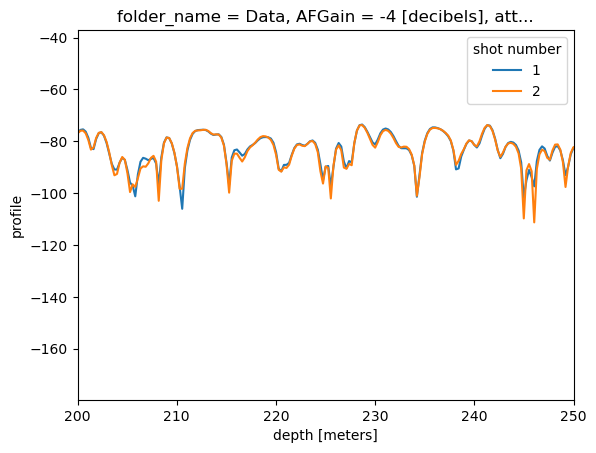

In [37]:
w.profile.dB().sel(time = '2024-12-10 09:00', attenuator_setting_pair = 0).plot(hue='shot_number', xlim = (200, 250));

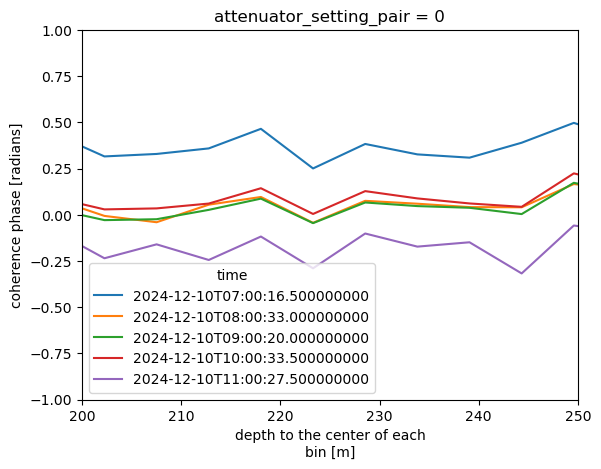

In [46]:
w.phase.sel(time = slice('2024-12-10 07:00','2024-12-10 11:00'), attenuator_setting_pair = 0).plot(hue='time', xlim = (200, 250), ylim = (-1, 1));

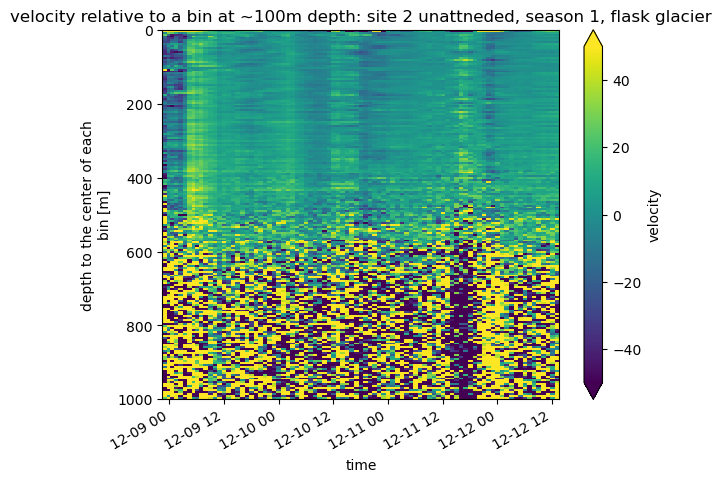

In [20]:
(w.velocity-w.velocity.sel(bin_depth=100,method='nearest')).isel(attenuator_setting_pair = 0).plot(x='time' , ylim=(1000, 0), vmin=-50, vmax =50);
plt.title('velocity relative to a bin at ~100m depth: site 2 unattneded, season 1, flask glacier')
plt.savefig('w_rel_to_100m.png')

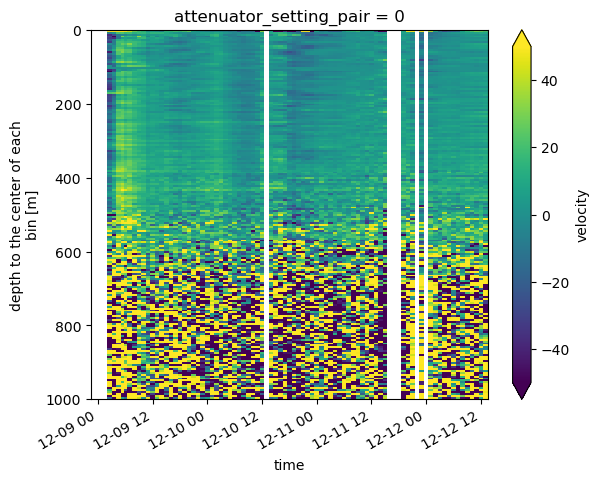

In [16]:
filter = np.abs(w.coherence.sel(bin_depth = slice(0,500)).mean(dim='bin_depth'))>0.9
(w.velocity-w.velocity.sel(bin_depth=100,method='nearest')).where(filter).isel(attenuator_setting_pair = 0).plot(x='time' , ylim=(1000, 0), vmin=-50, vmax =50);
#plt.title('velocity relative to a bin at ~100m depth')

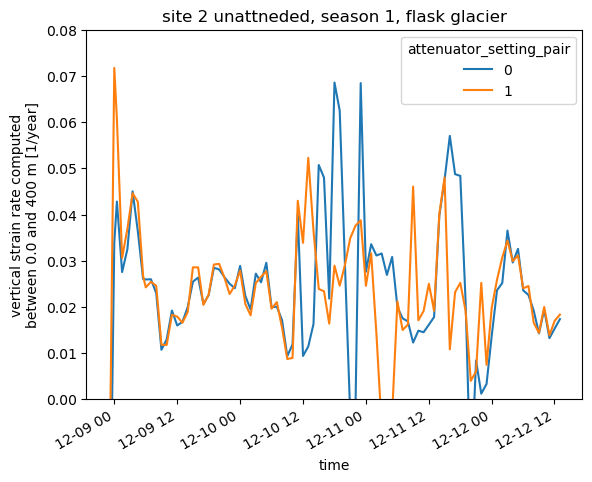

In [ ]:
w.strain_rate.plot.line(x='time', hue='attenuator_setting_pair', ylim = (0, 0.08));



In [80]:
w.strain_rate.hvplot(x='time', y = 'strain_rate', by='attenuator_setting_pair', figsize=(15, 5), ylim = (0,0.08)) + ds_c.temperature_2.hvplot(x='time' )


:Layout
   .NdOverlay.I :NdOverlay   [attenuator_setting_pair]
      :Curve   [time]   (vertical strain rate computed between 0.0 and 400 m)
   .Curve.I     :Curve   [time]   (temperature measured inside the ApRES unit in a second location)

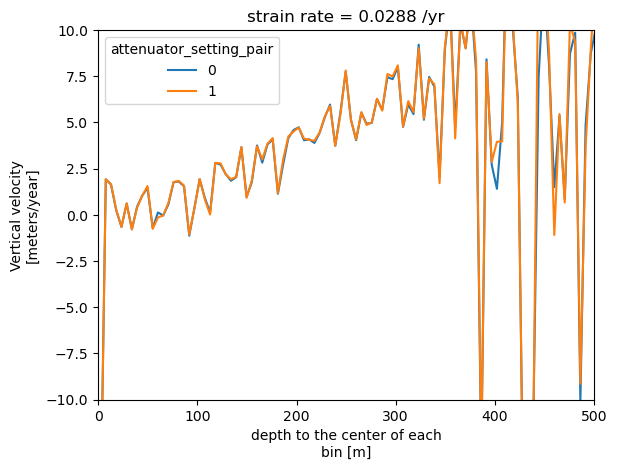

In [74]:
two_profiles_w = xa.utils.compute_displacement(ds_c.profile.isel(time = 20).mean('chirp_num'), ds_c.profile.isel(time = -1).mean('chirp_num'), max_depth_for_ezz_fit=300)

two_profiles_w.velocity.plot(hue = 'attenuator_setting_pair', xlim=(0,500), ylim = (-10, 10)) 
plt.title(f"strain rate = {two_profiles_w.strain_rate.mean().values:.4f} /yr");

In [6]:
import xarray_grid_search as xgs
import numpy as np

/Users/jkingslake/Documents/projects/current_projects/AntPen_NSF_NERC/AntPen_NSF_NERC/code/apres/season_1/xarray_grid_search.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [128]:
stacked

<xarray.Dataset>
Dimensions:          (time: 94, attenuator_setting_pair: 2, chirp_time: 40000,
                      profile_range: 39999)
Coordinates:
  * chirp_time       (chirp_time) float64 0.0 2.5e-05 5e-05 ... 0.9999 1.0 1.0
    filename         (time) <U23 'DATA2024-12-08-1958.DAT' ... 'DATA2024-12-1...
    folder_name      (time) <U4 'Data' 'Data' 'Data' ... 'Data' 'Data' 'Data'
    burst_number     (time) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    AFGain           (time, attenuator_setting_pair) int64 -4 -14 -4 ... -4 -14
    attenuator       (time, attenuator_setting_pair) float64 20.0 10.0 ... 10.0
    orientation      (time) <U7 'unknown' 'unknown' ... 'unknown' 'unknown'
  * time             (time) datetime64[ns] 2024-12-08T16:58:30 ... 2024-12-12...
  * profile_range    (profile_range) float64 0.0 0.2103 ... 8.411e+03 8.411e+03
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (time, attenuator_setting_pair, chirp_time) float64 0.01...
    latitude         (time) float64 -65.78 -65.78 -65.78 ... -65.78 -65.78
    longitude        (time) float64 -62.69 -62.69 -62.69 ... -62.69 -62.69
    battery_voltage  (time) float64 12.89 12.73 12.69 ... 12.15 12.15 12.14
    temperature_1    (time) float64 27.51 45.15 44.36 ... 26.33 24.96 25.16
    temperature_2    (time) float64 29.88 44.39 40.27 ... 25.17 26.55 26.94
    profile          (time, attenuator_setting_pair, profile_range) complex128 ...

In [129]:
results = xgs.gridSearch(stacked.profile.displacement_timeseries, 
               min_depth_for_ezz_fit = [20], 
               max_depth_for_ezz_fit = [300, 400], 
               offset = [3], 
               bin_size = [10, 20, 30, 40])
depth_filter = (results.bin_depth < results.max_depth_for_ezz_fit) & (results.bin_depth > results.min_depth_for_ezz_fit)
coherence_filter = np.abs((results.coherence.where(depth_filter)).mean(dim='bin_depth'))>0.95

  0%|          | 0/8 [00:00<?, ?it/s]

In [130]:
results.strain_rate.where(coherence_filter).hvplot.line(x='time', by ='attenuator_setting_pair', ylim = (0, 0.08), height = 400, width = 800)# + ds_c.temperature_1.hvplot(x='time' ) * ds_c.temperature_2.hvplot(x='time' )

BokehModel(combine_events=True, render_bundle={'docs_json': {'ca3ed063-47ff-418a-92e3-c2fe76f8ce4d': {'version…

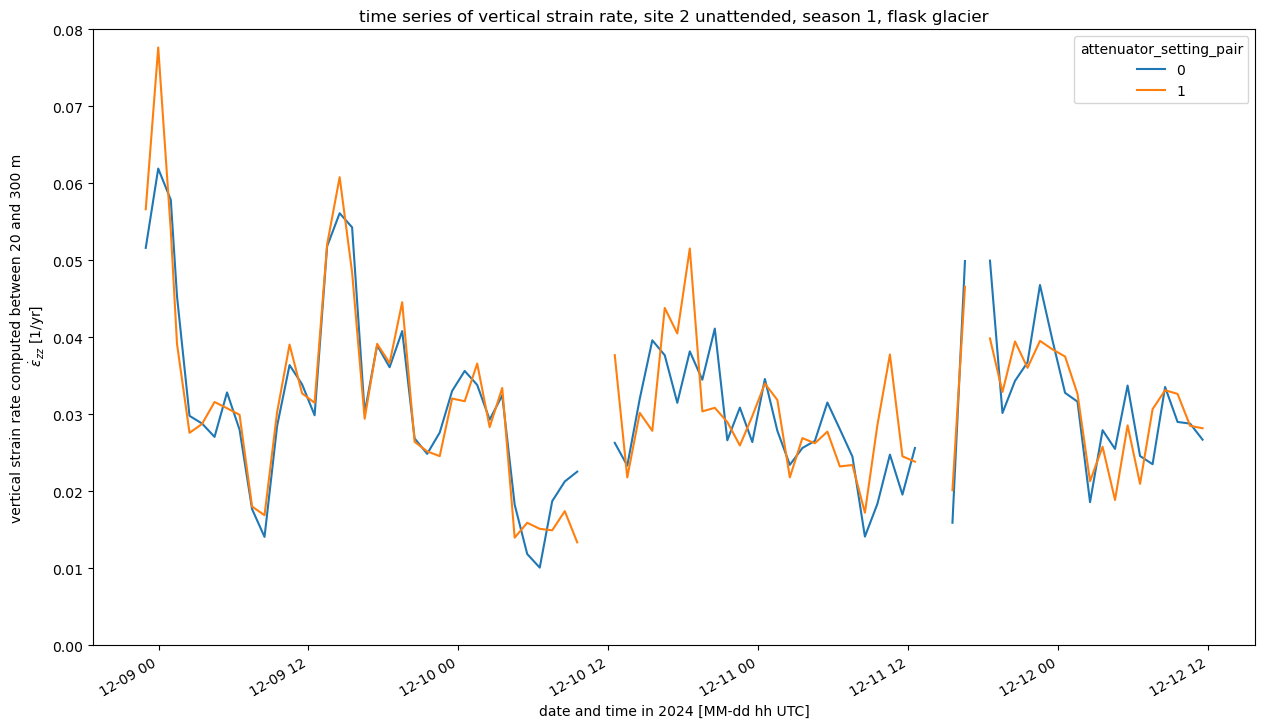

In [131]:
results.strain_rate.where(coherence_filter).sel(bin_size=20, min_depth_for_ezz_fit=20, max_depth_for_ezz_fit=300).plot(x='time', hue = 'attenuator_setting_pair', ylim = (0, 0.08), figsize = (15, 8))
plt.ylabel('vertical strain rate computed between 20 and 300 m\n $\dot{\epsilon}_{zz}$ [1/yr]')
plt.xlabel('date and time in 2024 [MM-dd hh UTC]')
plt.title('time series of vertical strain rate, site 2 unattended, season 1, flask glacier')
plt.savefig('strain_rate_time_series.png')

In [79]:
results.nbytes/1e9

4.560345732

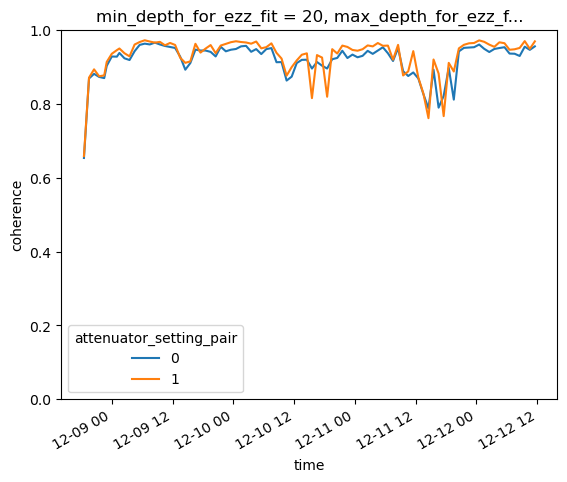

In [140]:
np.abs(results.coherence).sel(bin_size = 20, bin_depth = slice(0,500),min_depth_for_ezz_fit=20, max_depth_for_ezz_fit = 300).mean('bin_depth').squeeze().plot.line(hue ='attenuator_setting_pair', x = 'time', ylim = (0,1))
#plt.title('coherence_mag: site 2 unattneded, season 1, flask glacier')
#plt.savefig('coherence_mag.png')

In [141]:
results.strain_rate.where(coherence_filter).hvplot.line(by ='attenuator_setting_pair',x = 'time', ylim = (-0.02,0.08),width = 1000, height = 600, legend=False)

BokehModel(combine_events=True, render_bundle={'docs_json': {'390f0625-10c9-4a49-beb6-976b7307ff4a': {'version…

In [142]:
np.abs((results.coherence.where(depth_filter)).mean(dim='bin_depth')).hvplot.line(by ='attenuator_setting_pair',x = 'time', ylim = (0,1), width = 1000, height = 600, legend=False)

BokehModel(combine_events=True, render_bundle={'docs_json': {'2743cb1a-b438-4615-a2aa-cdb3b53e85b1': {'version…

In [148]:
def pair_profile(i1, i2):
    return xa.utils.compute_displacement(stacked.profile.isel(time = i1), stacked.profile.isel(time = i2), max_depth_for_ezz_fit=400)
gs = xgs.gridSearch(pair_profile, i1 = [0,5,10], i2 = [40, 45, 57])
#gs.isel(attenuator_setting_pair = 0).hvplot.line(x = 'bin_depth', y = 'velocity', ylim = (-10, 10), xlim = (0, 400))
gs

  0%|          | 0/9 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:                  (i1: 3, i2: 3, profile_range: 39999, time: 9,
                              shot_number: 2, attenuator_setting_pair: 2,
                              bin_depth: 1999)
Coordinates: (12/14)
  * i1                       (i1) int64 0 5 10
  * i2                       (i2) int64 40 45 57
  * profile_range            (profile_range) float64 0.0 0.2103 ... 8.411e+03
  * time                     (time) datetime64[ns] 2024-12-09T12:29:34 ... 20...
  * shot_number              (shot_number) int64 1 2
  * attenuator_setting_pair  (attenuator_setting_pair) int64 0 1
    ...                       ...
    folder_name              <U4 'Data'
    burst_number             (shot_number) int64 0 0
    AFGain                   (attenuator_setting_pair) int64 -4 -14
    attenuator               (attenuator_setting_pair) float64 20.0 10.0
    orientation              <U7 'unknown'
    profile_time             (shot_number, time, i1, i2) datetime64[ns] 2024-...
Data variables:
    profile                  (shot_number, time, attenuator_setting_pair, profile_range, i1, i2) complex128 ...
    coherence                (time, attenuator_setting_pair, bin_depth, i1, i2) complex128 ...
    phase                    (time, attenuator_setting_pair, bin_depth, i1, i2) float64 ...
    phase_uncertainty        (time, attenuator_setting_pair, bin_depth, i1, i2) float64 ...
    displacement             (time, attenuator_setting_pair, bin_depth, i1, i2) float64 ...
    disp_uncertainty         (time, attenuator_setting_pair, bin_depth, i1, i2) float64 ...
    velocity                 (time, attenuator_setting_pair, bin_depth, i1, i2) float64 ...
    strain_rate              (attenuator_setting_pair, i1, i2) float64 0.0306...
    surface_intercept        (attenuator_setting_pair, i1, i2) float64 -13.7 ...
    r_squared                (attenuator_setting_pair, i1, i2) float64 0.1964...
Attributes:
    long_name:    profile
    units:        -
    description:  Time series of profiles of coherence, phase, displacement, ...
    constants:    {'T': 1, 'f_1': 200000000.0, 'f_2': 400000000.0, 'B': 20000...
    bin_size:     20
    processing:   Created by the compute_displacement function in xapres usin...

In [152]:
gs.velocity.isel(attenuator_setting_pair = 0).hvplot.line(x = 'bin_depth', y = 'velocity', xlim = (0, 400))

BokehModel(combine_events=True, render_bundle={'docs_json': {'71bc89a5-dfb0-4fe6-8663-3614c0d40735': {'version…

## Weather station data

In [4]:
import pandas as pd


In [5]:
# load nc to xarray
aws = xr.open_dataset('../../aws/aws_season_1.nc')

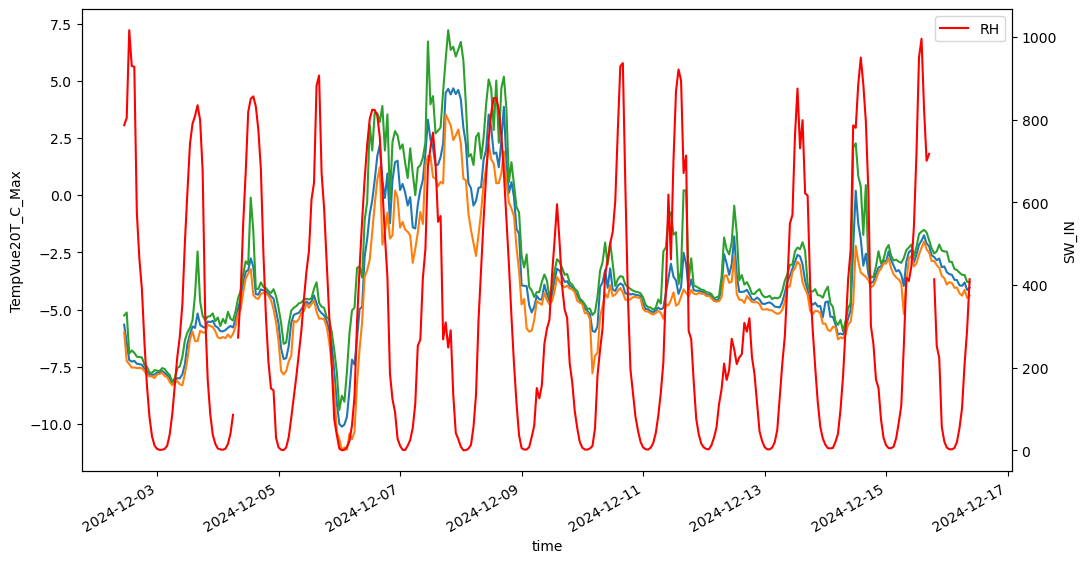

In [232]:
fig, ax = plt.subplots(figsize=(12,6))

ax2 = ax.twinx()

aws.TempVue20T_C_Avg.plot(ax=ax, label = 'average T')
aws.TempVue20T_C_Min.plot(ax=ax, label = 'min T')
aws.TempVue20T_C_Max.plot(ax=ax, label = 'max T')
#plt.legend()

aws.SW_IN.plot(ax=ax2, color = 'red', label = 'RH')
plt.legend()

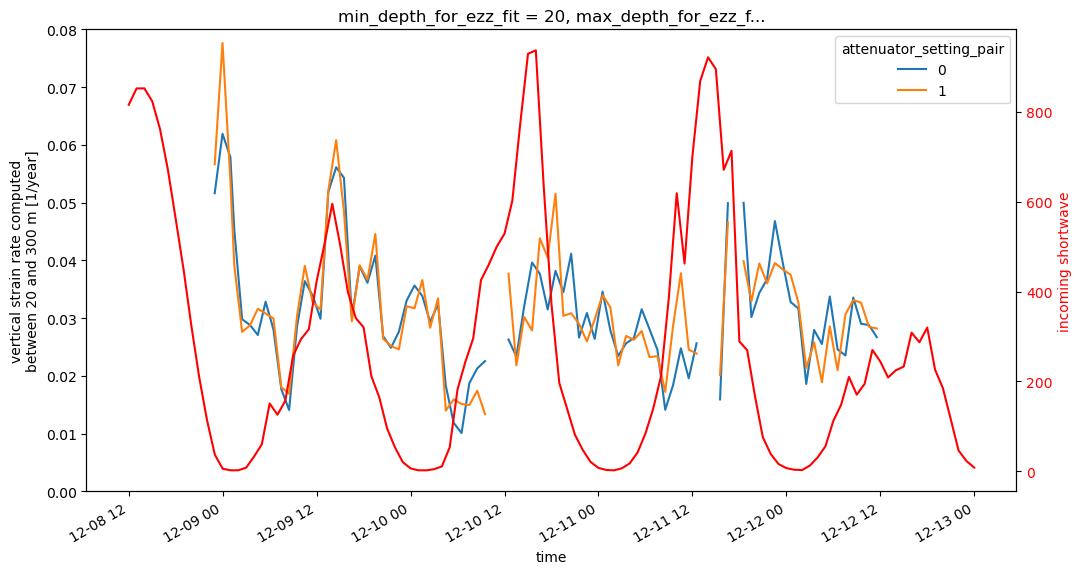

In [175]:
fig, ax = plt.subplots(figsize=(12,6))

ax2 = ax.twinx()
results.strain_rate.where(coherence_filter).sel(bin_size=20, min_depth_for_ezz_fit=20, max_depth_for_ezz_fit=300).plot(ax = ax, x='time', hue = 'attenuator_setting_pair', ylim = (0, 0.08))
aws.SW_IN.sel(time = slice('2024-12-08 12:00', '2024-12-13 00:00')).plot(ax=ax2, color = 'red', label = 'RH')
ax2.set_ylabel('incoming shortwave', color='red')
ax2.tick_params(axis='y', labelcolor='red')



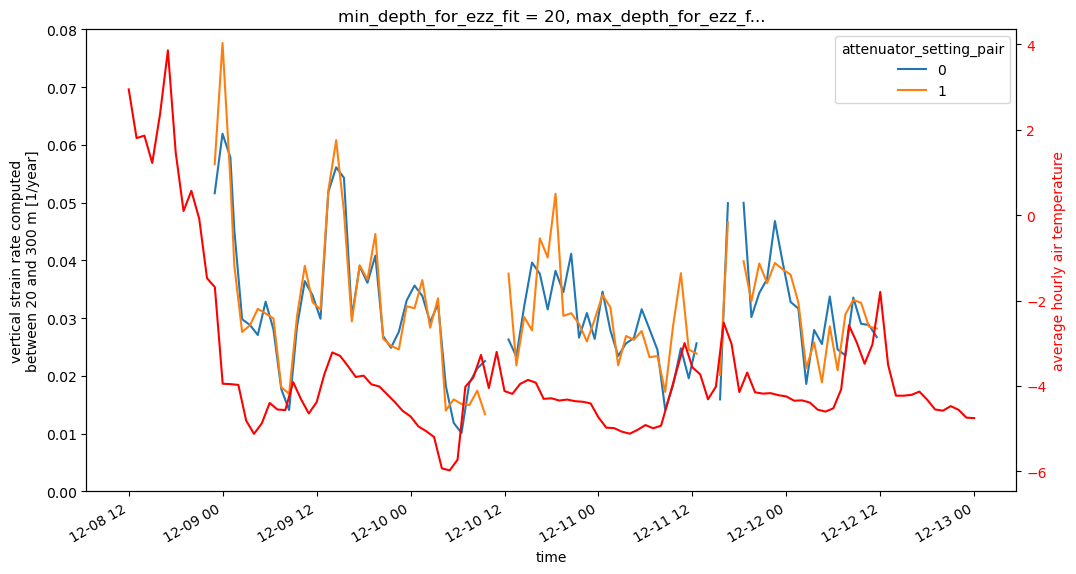

In [176]:
fig, ax = plt.subplots(figsize=(12,6))

ax2 = ax.twinx()
results.strain_rate.where(coherence_filter).sel(bin_size=20, min_depth_for_ezz_fit=20, max_depth_for_ezz_fit=300).plot(ax = ax, x='time', hue = 'attenuator_setting_pair', ylim = (0, 0.08))
aws.TempVue20T_C_Avg.sel(time = slice('2024-12-08 12:00', '2024-12-13 00:00')).plot(ax=ax2, color = 'red', label = 'Average hourly T')
ax2.set_ylabel('average hourly air temperature', color='red')
ax2.tick_params(axis='y', labelcolor='red')



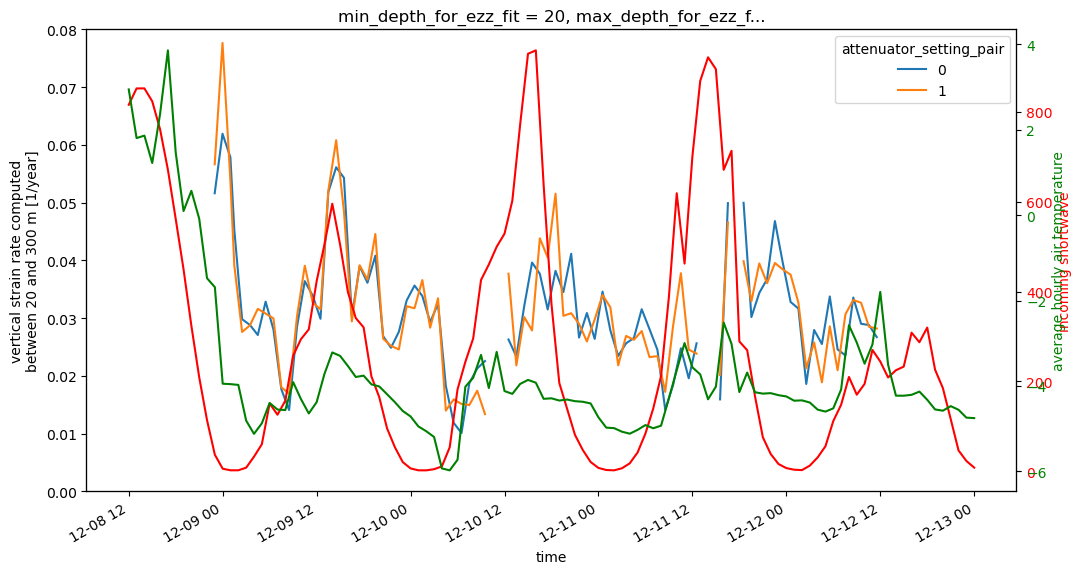

In [180]:
fig, ax = plt.subplots(figsize=(12,6))

ax2 = ax.twinx()
ax3 = ax.twinx()

results.strain_rate.where(coherence_filter).sel(bin_size=20, min_depth_for_ezz_fit=20, max_depth_for_ezz_fit=300).plot(ax = ax, x='time', hue = 'attenuator_setting_pair', ylim = (0, 0.08))
aws.SW_IN.sel(time = slice('2024-12-08 12:00', '2024-12-13 00:00')).plot(ax=ax2, color = 'red', label = 'RH')
ax2.set_ylabel('incoming shortwave', color='red')
ax2.tick_params(axis='y', labelcolor='red')

aws.TempVue20T_C_Avg.sel(time = slice('2024-12-08 12:00', '2024-12-13 00:00')).plot(ax=ax3, color = 'green', label = 'Average hourly T')
ax3.set_ylabel('average hourly air temperature', color='green')
ax3.tick_params(axis='y', labelcolor='green')



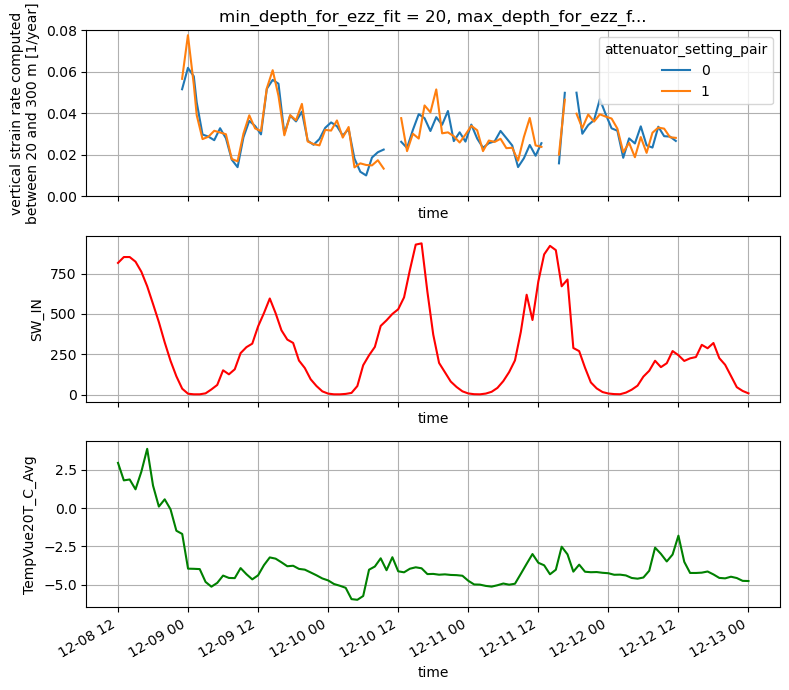

In [233]:
fig, axs = plt.subplots(3,1, figsize=(8,7), sharex=True)

results.strain_rate.where(coherence_filter).sel(bin_size=20, min_depth_for_ezz_fit=20, max_depth_for_ezz_fit=300).plot(ax = axs[0], x='time', hue = 'attenuator_setting_pair', ylim = (0, 0.08))

aws.SW_IN.sel(time = slice('2024-12-08 12:00', '2024-12-13 00:00')).plot(ax=axs[1], color = 'red', label = 'RH')
#ax2.set_ylabel('incoming shortwave', color='red')
#ax2.tick_params(axis='y', labelcolor='red')

aws.TempVue20T_C_Avg.sel(time = slice('2024-12-08 12:00', '2024-12-13 00:00')).plot(ax=axs[2], color = 'green', label = 'Average hourly T')
#ax3.set_ylabel('average hourly air temperature', color='green')
#ax3.tick_params(axis='y', labelcolor='green')
fig.tight_layout()

for ax in axs:
    ax.grid()

plt.savefig('strain_rate_vs_met.png')

In [6]:
aws.nbytes

150080